In [180]:
from noise_generator import generate_noise_trajectory, monte_carlo_noise
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from system import *
import scqubits

In [181]:
from scipy.optimize import golden
class Hamiltonian:
    def __init__(self, phi_ex, Ej, Ec, trunc):
        self.phi_ex = phi_ex
        self.Ej = Ej * 2*np.pi
        self.Ec = Ec * 2*np.pi
        self.beta = 1
        self.N = 1
        self.sdim = 10
        self.cdim = 6
        self.epsilon =1e-6
        self.trunc = trunc
        self.total_dim = trunc[-1]*trunc[-2]
        self.get_H()
        self.get_H_der()
        self.get_noise_operator()
        self.get_projectors()
        
        

    def annihilation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),1)
    def creation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),-1)

        
    def get_indices(self, dims):
        """
        Convert a list of 2D indices to 1D indices based on given dimensions.
        
        Args:
            dims: List of two integers [N,K] specifying the dimensions to include
                 N is number of cavity states
                 K is number of SNAIL states
                 
        Returns:
            List of 1D indices corresponding to the 2D indices
        """
        N, K = dims
        indices_2d = []
        indices_1d = []
        
        # Generate all 2D indices and store indices outside truncation
        for n in range(self.sdim):
            for k in range(self.cdim):
                # Only add indices that are outside the truncation
                if n >= N or k >= K:
                    indices_2d.append(f"{n}{k}")
                    # Convert to 1D index using n*cdim + k
                    idx = n*self.cdim + k
                    indices_1d.append(idx)

        return indices_1d
        
    def remove_row_col(self, matrix, indices):
        # Check if matrix is square
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError("Input matrix must be square")
        
        # Convert single index to list if needed
        if isinstance(indices, (int, np.integer)):
            indices = [indices]
            
        # Convert to list if numpy array
        if isinstance(indices, np.ndarray):
            indices = indices.tolist()
            
        # Sort indices in descending order to avoid changing indices when deleting
        indices = sorted(indices, reverse=True)
        
        # Check if indices are valid
        if any(i < 0 or i >= matrix.shape[0] for i in indices):
            raise ValueError(f"All indices must be between 0 and {matrix.shape[0]-1}")
        
        # Remove rows and columns
        result = matrix.copy()
        for idx in indices:
            result = np.delete(np.delete(result, idx, axis=0), idx, axis=1)
            
        return result
    
    def truncate_matrix(self, matrix, trunc):
        indices = self.get_indices(trunc)
        return self.remove_row_col(matrix, indices)
    
    def get_H(self):
        #if we want to use scqubits, replace Hs,charge_op with the ones obtained from scqubits
        Hs,charge_op, phi_zpf = SNAIL(self.phi_ex, self.beta, self.N, self.Ej, self.Ec)
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control = composite_sys(squid,cavity)
        evals,U = np.linalg.eigh(H)
        evals,U = sort_eigenpairs(evals,U)
        evals = evals - evals[0]
        Ud = U.T.conj()
        self.U1 = U
        self.Ud1 = Ud

        self.omega_c = evals[1]
        self.omega_s = evals[self.cdim]
        self.chi = evals[self.cdim+1] - evals[self.cdim] - evals[1]
        self.anh = evals[2*self.cdim] - 2*evals[self.cdim]
        self.phi_zpf = phi_zpf
        self.H, self.H_control = H,H_control

        cavity_sigmax = np.zeros((self.cdim, self.cdim))
        cavity_sigmax[0,1] = 1
        cavity_sigmax[1,0] = 1
        sigmaxc = np.kron(np.eye(self.sdim), cavity_sigmax)
        self.sigmaxc = self.truncate_matrix(sigmaxc, self.trunc)
        squid_sigmax = np.zeros((self.sdim, self.sdim))
        squid_sigmax[0,1] = 1
        squid_sigmax[1,0] = 1
        sigmaxs = np.kron(squid_sigmax, np.eye(self.cdim))
        self.sigmaxs = self.truncate_matrix(sigmaxs, self.trunc)
    
    
        
    def get_H_der(self):
        original_phi = self.phi_ex
        Hs,charge_op, phi_zpf = SNAIL(self.phi_ex+self.epsilon, self.beta, self.N, self.Ej, self.Ec)
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control = composite_sys(squid,cavity)
        evals,U = np.linalg.eigh(H)
        evals,U = sort_eigenpairs(evals,U)
        evals = evals - evals[0]
        Ud = U.T.conj()

        self.H_per = H
        self.H_control_per = H_control

        self.omega_s_per = evals[self.cdim]
        self.omega_c_per = evals[1]

    def get_noise_operator(self):
        H_per = self.H_per
        H = self.H
        self.noise = (H_per - H) / self.epsilon
        
        # s = self.annihilation(self.sdim)
        # sd = self.creation(self.sdim)
        # ic = np.identity(self.cdim)
        # self.noise = self.truncate_matrix(np.kron(sd@s, ic), self.trunc)

        self.noise = self.Ud1@self.noise@self.U1
        
        self.noise = self.truncate_matrix(self.noise, self.trunc)
        self.H = self.Ud1@self.H@self.U1
        self.H = self.truncate_matrix(self.H, self.trunc)
        self.H_control = self.Ud1@self.H_control@self.U1
        self.H_control = self.truncate_matrix(self.H_control, self.trunc)
    
    def get_projectors(self):
        trunc = self.trunc
        truncated_total_dim = trunc[-1]*trunc[-2]
        projectors = []
        for i in range(truncated_total_dim):
            projector = qt.basis(truncated_total_dim, i)*qt.basis(truncated_total_dim, i).dag()

            projectors.append(projector)
        self.projectors = projectors
        

    def static_rate(self, der):
        A = 5e-6
        return np.abs(der*4.4)*1e6*A
    
    def calculate_dr_exact(self, A, omega):
        energy01,energy02,energy03= calculate_floquet_energies(A, omega, self.H, self.H_control)
        energy01_,energy02_,energy03_ = calculate_floquet_energies(A, omega, self.H_per, self.H_control_per)
        der1 = (energy01_ - energy01) / self.epsilon
        return self.static_rate(der1)

    
    def optimal_omegad(self, A):
        # Create a wrapper function that ensures we return a Python float
        def calculate_dr_wrapper(A, omega_d):
            result = self.calculate_dr_exact(A, omega_d)
            return float(result)

        # Define objective function
        def objective(omega_d):
            return calculate_dr_wrapper(A, omega_d)

        # Try different bracketing values until we find ones that work
        omega_min = 5.8 * 2 * np.pi
        omega_max = 6.4 * 2 * np.pi
        n_points = 10
        omega_range = np.linspace(omega_min, omega_max, n_points)
        
        # Find minimum point among test points
        rates = [objective(omega) for omega in omega_range]
        min_idx = np.argmin(rates)
        
        if min_idx == 0 or min_idx == len(omega_range)-1:
            # If minimum is at edge, return that value
            optimal_omega = omega_range[min_idx]
            min_rate = rates[min_idx]
        else:
            # Use points around minimum for bracketing
            xa = omega_range[min_idx-1]
            xb = omega_range[min_idx]
            xc = omega_range[min_idx+1]
            
            # Use golden section search for optimization
            optimal_omega = golden(objective, brack=(xa, xb, xc))
            min_rate = objective(optimal_omega)
        
        return optimal_omega/2/np.pi, min_rate
    

    def calculate_floquet_U(self, A, omega):
        # Define system parameters
        H0 = qt.Qobj(self.H)
        Hc = qt.Qobj(self.H_control)

        T = (2 * np.pi) / omega

        # Define the Hamiltonian
        H = [H0, [Hc, lambda t, args: A * np.cos(args['w'] * t)]]

        # Set up the Floquet solver
        floquet_basis = qt.FloquetBasis(H, T, args={'w': omega})

        # Compute Floquet modes and energies
        f_modes = floquet_basis.mode(0)
        f_energies = floquet_basis.e_quasi
        f_modes = np.array(f_modes)
        # Convert list of Qobj to numpy array
        f_modes_array = []
        for mode in f_modes:
            f_modes_array.append(mode.full().flatten())
        f_modes = np.array(f_modes_array)
        f_modes = f_modes.T
        evals, U = sort_eigenpairs(f_energies,f_modes)
        Ud = U.T.conj()
        self.sigmax_dressed = Ud@self.sigmaxc@U
        initial_state = np.sqrt(1/2)*(U[:,0] + U[:,1])
        return initial_state, self.sigmax_dressed,
    
    def calculate_floquet_U_test(self, A, omega):
        # Define system parameters
        H0 = qt.Qobj(self.H)
        Hc = qt.Qobj(self.H_control)

        T = (2 * np.pi) / omega

        # Define the Hamiltonian
        H = [H0, [Hc, lambda t, args: A * np.cos(args['w'] * t)]]

        # Set up the Floquet solver
        floquet_basis = qt.FloquetBasis(H, T, args={'w': omega})

        # Compute Floquet modes and energies
        f_modes = floquet_basis.mode(0)
        f_energies = floquet_basis.e_quasi
        f_modes = np.array(f_modes)
        # Convert list of Qobj to numpy array
        f_modes_array = []
        for mode in f_modes:
            f_modes_array.append(mode.full().flatten())
        f_modes = np.array(f_modes_array)
        f_modes = f_modes.T
        evals, U = sort_eigenpairs(f_energies,f_modes)
        Ud = U.T.conj()
        noise = Ud@self.noise@U
        H = Ud@self.H@U
        H_control = Ud@self.H_control@U
        return noise, H, H_control



In [182]:
import numpy as np

def zero_first_two_rows_cols(matrix, idx):
    """
    Set the first two rows and first two columns of a given matrix to zero.
    
    Args:
        matrix (numpy.ndarray): Input matrix.
        
    Returns:
        numpy.ndarray: Matrix with the first two rows and first two columns set to zero.
    """
    new_matrix = matrix.copy()
    new_matrix[:idx, :] = 0
    new_matrix[:, :idx] = 0
    return new_matrix


In [189]:
def _single_trajectory(idx, sample_rate, t_max, relative_PSD_strength, f0, white, H0, init_state, H_control, A, optimal_omega, noise,ex_ops):
    t_list, shifts, _, freq_list, psd = generate_noise_trajectory(sample_rate, t_max, relative_PSD_strength, f0, white)
    args = {'w': optimal_omega}
    noise_op = qt.Qobj(noise)
    w_d = 0*2*np.pi
    H_tot = [H0, [noise_op, shifts]]
    options = {'nsteps': 100000, 'atol': 1e-13, 'rtol': 1e-13}  # Increase nsteps to handle the integration
    result = qt.sesolve(H_tot, init_state, t_list, e_ops=ex_ops, args=args, options=options)
    return shifts, result.expect, psd, t_list, freq_list

# Parameters
sample_rate = 1                      # per ns
t_max = 1000                         # in ns
relative_PSD_strength = (12e-3)**2    # sets frequency noise PSD at zero frequency, in (us^-2)/sample_rate
f0 = 1e-2                            # sets cut-off for low-pass filtered noise, in us^-1

phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [4,3])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
init_state = (qt.basis(sc.total_dim, 0) + qt.basis(sc.total_dim, 1)).unit()
sigmax = qt.Qobj(sc.sigmaxc)
A = 0.
omega = 10*2*np.pi
noise = sc.noise
# noise[1,1] = noise[2,2] = noise[3,3] = 0
projectors = sc.projectors
ex_ops = [*projectors, sigmax]

# Generate single trajectory
shifts, expect, psd, t_list, freq_list = _single_trajectory(
    0, sample_rate, t_max, relative_PSD_strength, f0, False,
    H0, init_state, H_control, A, omega, noise, ex_ops
)

# Store results
trajectory = shifts
Xtraj = np.array(expect)
noise_psd = psd


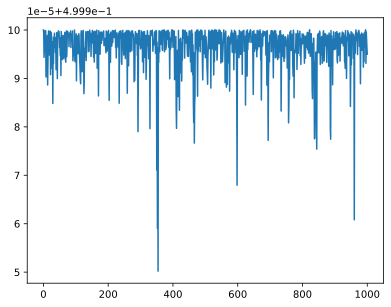

In [190]:
plt.plot(Xtraj[1])

In [72]:
init_state

Quantum object: dims=[[4], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.70710678]
 [0.70710678]
 [0.        ]
 [0.        ]]

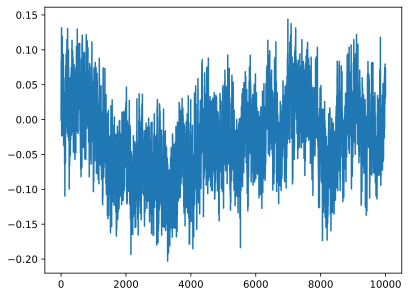

In [40]:
plt.plot(trajectory)

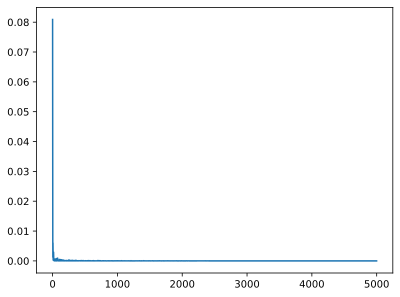

In [41]:
plt.plot(psd)

 /Users/yunwei/Desktop/PycharmProjects/qutip/qutip/solver/options.py: 16ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/matplotlib/cbook.py: 1709ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/matplotlib/cbook.py: 1345

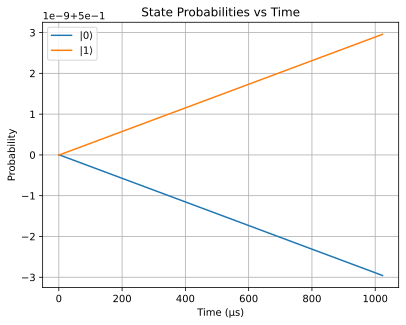

In [166]:
# Parameters for 1 GHz qubit with weak drive
qubit_freq = 1.0  # GHz

# Convert to angular frequency in GHz
omega_q = 2*np.pi*qubit_freq  # GHz

# New Hamiltonian with qubit frequency and drive
H0_new = omega_q/2 * qt.Qobj([[0,0],[0,1]])  # Freequbit Hamiltonian
H_total = H0_new 

sample_rate = 1.0                  # per GHz
t_max = 1023                     # in GHz^-1
# Time points
t_list = np.linspace(0, t_max, int(1e3))
init_state = (qt.basis(2,0) + qt.basis(2,1)).unit()
# Solve Schrodinger equation
ex_ops = [qt.Qobj(np.array([[0,0],[0,1]]))]

# Create solver options with increased nsteps
options = qt.Options(nsteps=100000, atol=1e-13, rtol=1e-13)  # Increase nsteps to handle the integration
result = qt.sesolve(H_total, init_state, t_list, options=options)

# Calculate probabilities for |0⟩ and |1⟩ states over time
prob_0 = [state.overlap(qt.basis(2,0)) * np.conj(state.overlap(qt.basis(2,0))) for state in result.states]
prob_1 = [state.overlap(qt.basis(2,1)) * np.conj(state.overlap(qt.basis(2,1))) for state in result.states]

plt.figure()
plt.plot(t_list, prob_0, label='|0⟩')
plt.plot(t_list, prob_1, label='|1⟩')
plt.xlabel('Time (μs)')
plt.ylabel('Probability')
plt.title('State Probabilities vs Time')
plt.legend()
plt.grid(True)

In [153]:
H0

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[   0.            0.        ]
 [   0.         6283.18530718]]

In [144]:
ex_ops

[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[0. 0.]
  [0. 1.]]]

In [76]:
qt.qobj(np.array([[1,0],[0,0]]))

TypeError: 'module' object is not callable

In [77]:
qt.Qobj(np.array([[0,1],[0,0]]))

TypeError: 'module' object is not callable